In [ ]:
!pip install kaggle


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d mirichoi0218/insurance

Dataset URL: https://www.kaggle.com/datasets/mirichoi0218/insurance
License(s): DbCL-1.0
  0% 0.00/16.0k [00:00<?, ?B/s]
100% 16.0k/16.0k [00:00<00:00, 50.5MB/s]


In [ ]:
!unzip insurance.zip -d /content/dataset

Archive:  insurance.zip
  inflating: /content/dataset/insurance.csv  


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [ ]:
insurance = pd.read_csv("/content/dataset/insurance.csv",encoding = 'ISO-8859-1')
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [ ]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [ ]:
insurance.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [ ]:
insurance.isna().sum()

,0
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
charges,0


In [ ]:
insurance['smoker'].value_counts().sum()

np.int64(1338)

In [ ]:
numeric_cols = insurance.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = insurance.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_cols

['sex', 'smoker', 'region']

In [ ]:
binary_map = {"male": 1, "female": 0}
insurance['sex'] = insurance['sex'].map(binary_map)

binary_map_smoker = {"yes": 1, "no": 0}
insurance['smoker'] = insurance['smoker'].map(binary_map_smoker)

# One-hot encode region
insurance['region_original'] = insurance['region']
insurance = pd.get_dummies(insurance, columns=['region'], drop_first=True)


In [ ]:
insurance.head()

,age,sex,bmi,children,smoker,charges,region_original,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,southwest,False,False,True
1,18,1,33.770,1,0,1725.55230,southeast,False,True,False
2,28,1,33.000,3,0,4449.46200,southeast,False,True,False
3,33,1,22.705,0,0,21984.47061,northwest,True,False,False
4,32,1,28.880,0,0,3866.85520,northwest,True,False,False


In [ ]:
corr_matrix = insurance[numeric_cols].corr()
corr_matrix


,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


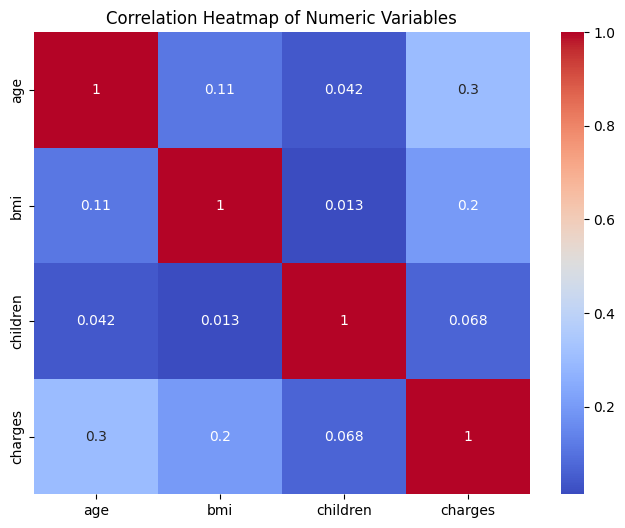

In [ ]:
# Heatmap of correlation matrix
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap of Numeric Variables")
plt.show()

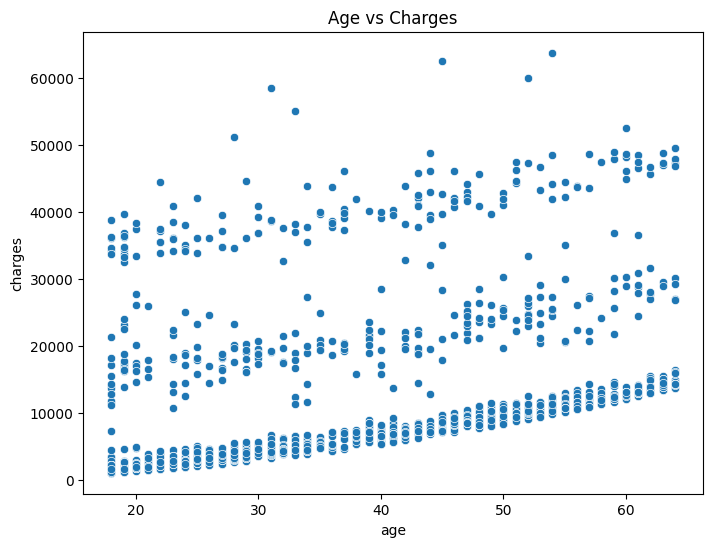

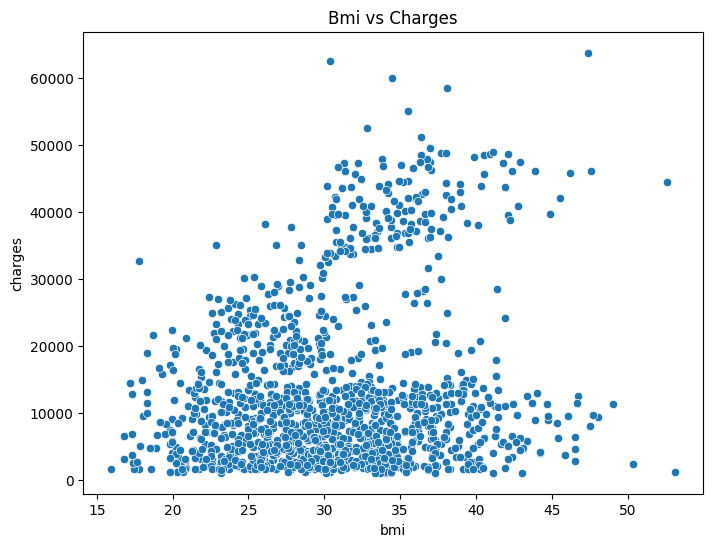

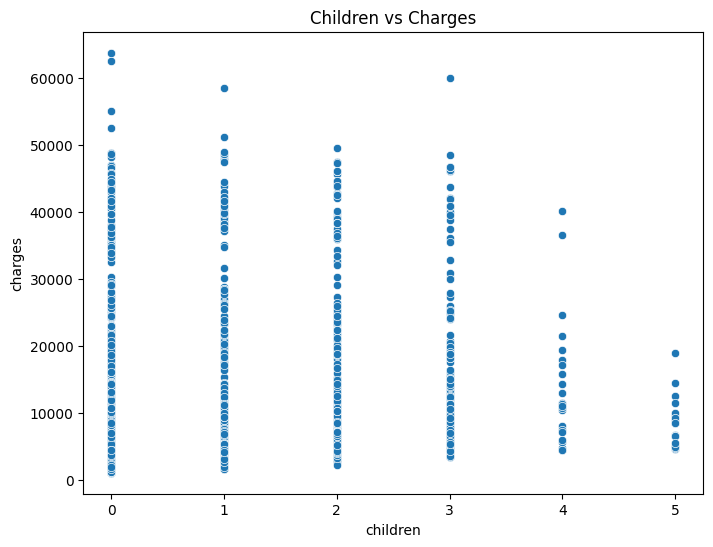

In [ ]:
# Scatterplots for each numeric column vs charges
for col in numeric_cols:
  if not col == 'charges':
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=col, y='charges', data=insurance)
    plt.title(f"{col.capitalize()} vs Charges")
    plt.show()

In [ ]:
children_mean = insurance.groupby('children')['charges'].mean().reset_index()
children_mean

,children,charges
0,0,12365.975602
1,1,12731.171832
2,2,15073.563734
3,3,15355.318367
4,4,13850.656311
5,5,8786.035247


/tmp/ipython-input-1933632750.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='children', y='charges', data=children_mean, palette='viridis')


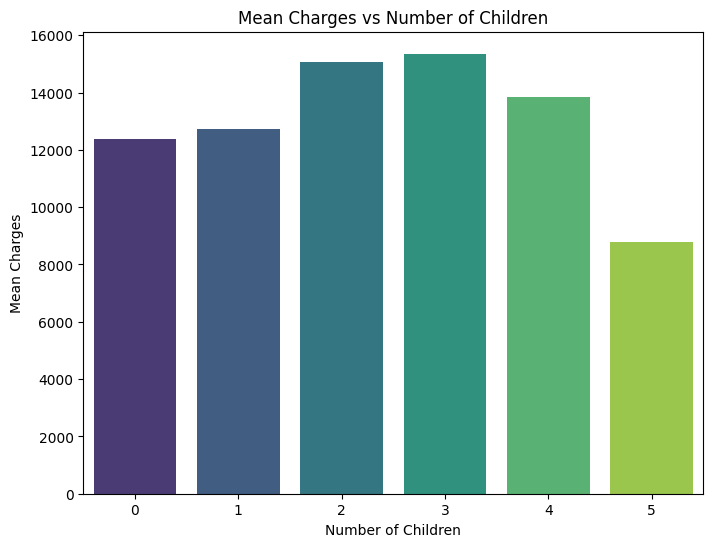

In [ ]:
plt.figure(figsize=(8,6))
sns.barplot(x='children', y='charges', data=children_mean, palette='viridis')
plt.title("Mean Charges vs Number of Children")
plt.ylabel("Mean Charges")
plt.xlabel("Number of Children")
plt.show()

In [ ]:
age_bins = [17, 25, 35, 45, 55, 65]
age_labels = ['18-24','25-34','35-44','45-54','55-64']
insurance['age_group'] = pd.cut(insurance['age'], bins=age_bins, labels=age_labels)
insurance['age_group']

,age_group
0,18-24
1,18-24
2,25-34
3,25-34
4,25-34
...,...
1333,45-54
1334,18-24
1335,18-24
1336,18-24


/tmp/ipython-input-1819470356.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_mean = insurance.groupby('age_group')['charges'].mean().reset_index()
/tmp/ipython-input-1819470356.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='age_group', y='charges', data=age_mean, palette='magma')


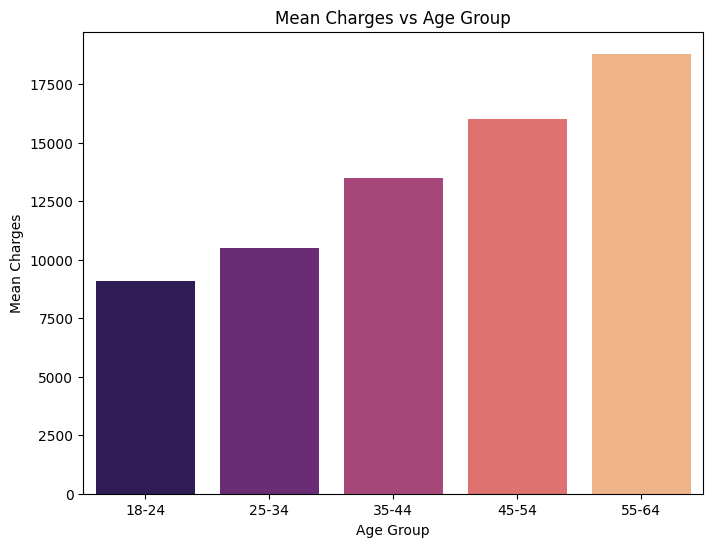

In [ ]:
# Mean charges per age group (bar)
age_mean = insurance.groupby('age_group')['charges'].mean().reset_index()
plt.figure(figsize=(8,6))
sns.barplot(x='age_group', y='charges', data=age_mean, palette='magma')
plt.title("Mean Charges vs Age Group")
plt.ylabel("Mean Charges")
plt.xlabel("Age Group")
plt.show()

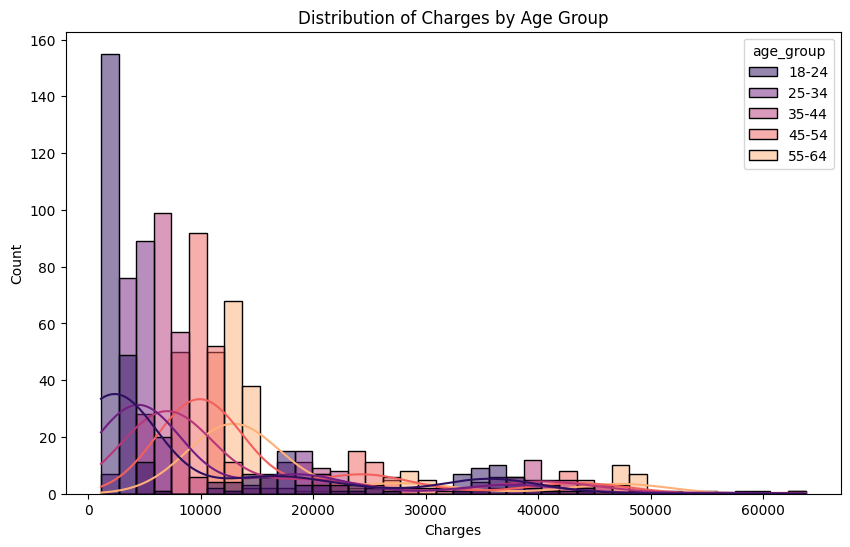

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(insurance, x='charges', hue='age_group', kde=True, palette='magma', bins=40)
plt.title("Distribution of Charges by Age Group")
plt.xlabel("Charges")
plt.show()

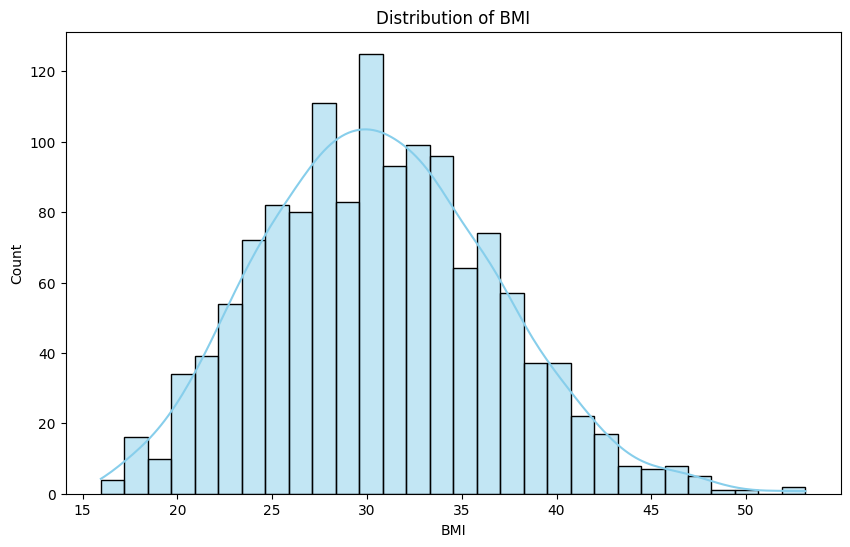

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(insurance, x='bmi', bins=30, kde=True, color='skyblue')
plt.title("Distribution of BMI")
plt.xlabel("BMI")
plt.show()

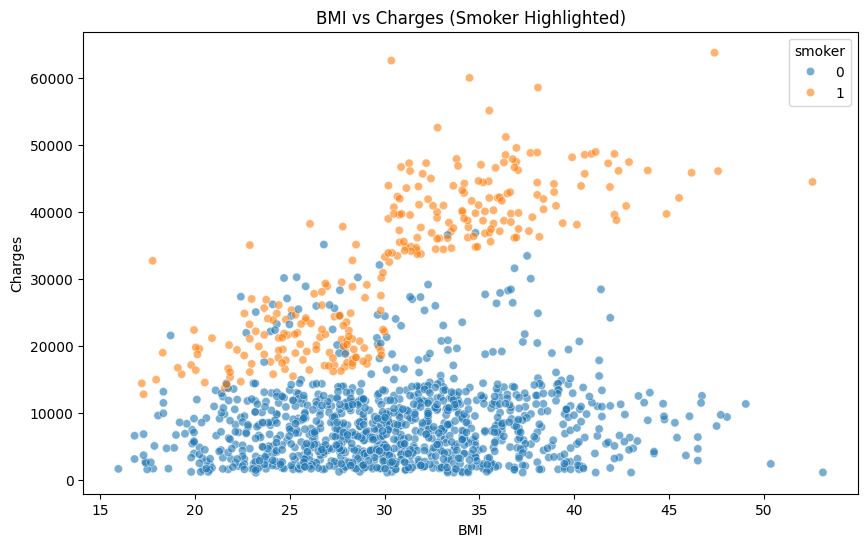

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='bmi', y='charges', hue='smoker', data=insurance, alpha=0.6)
plt.title("BMI vs Charges (Smoker Highlighted)")
plt.xlabel("BMI")
plt.ylabel("Charges")
plt.show()

/tmp/ipython-input-3842560551.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(x='children', y='charges', hue='smoker', data=insurance,


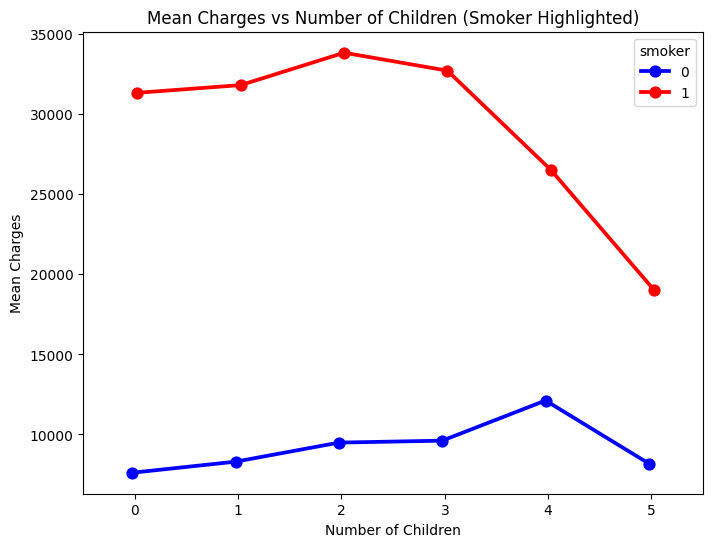

In [ ]:
plt.figure(figsize=(8,6))
sns.pointplot(x='children', y='charges', hue='smoker', data=insurance,
              palette={0:'blue',1:'red'}, dodge=True, ci=None)
plt.title("Mean Charges vs Number of Children (Smoker Highlighted)")
plt.xlabel("Number of Children")
plt.ylabel("Mean Charges")
plt.show()

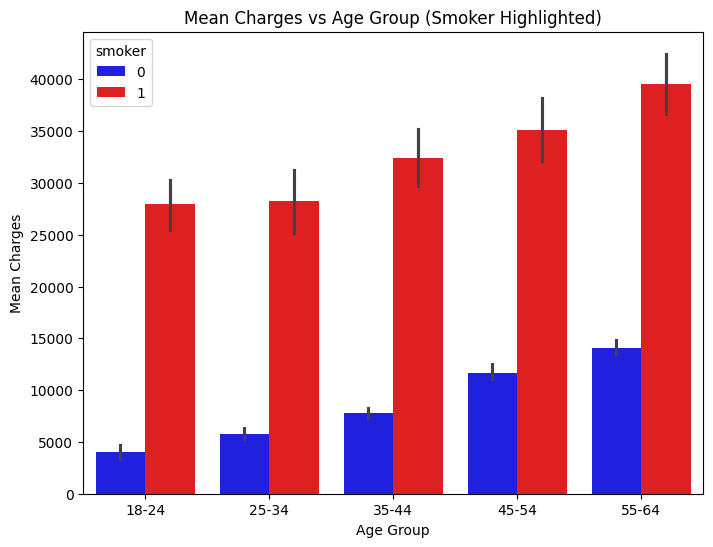

In [ ]:
plt.figure(figsize=(8,6))
sns.barplot(x='age_group', y='charges', hue='smoker', data=insurance,
            palette={0:'blue',1:'red'})
plt.title("Mean Charges vs Age Group (Smoker Highlighted)")
plt.xlabel("Age Group")
plt.ylabel("Mean Charges")
plt.show()

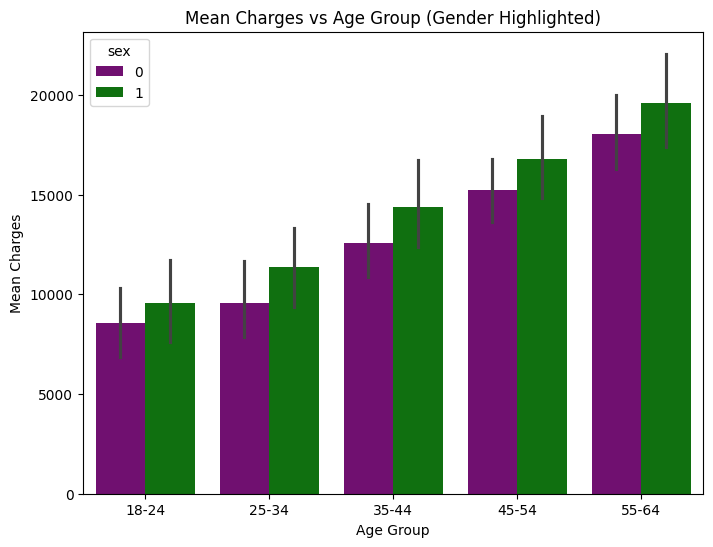

/tmp/ipython-input-105203137.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(x=col, y='charges', hue='sex', data=insurance,


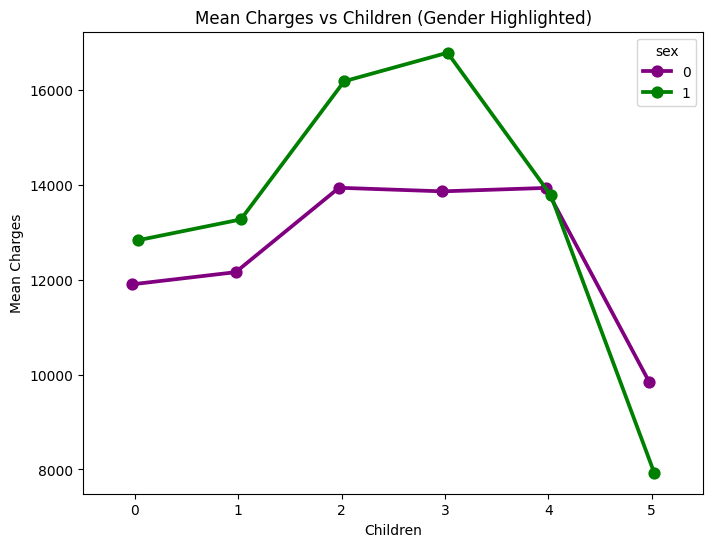

In [ ]:
for col in numeric_cols:
    if col == 'age':
        plt.figure(figsize=(8,6))
        sns.barplot(x='age_group', y='charges', hue='sex', data=insurance,
                    palette={0:'purple',1:'green'})
        plt.title("Mean Charges vs Age Group (Gender Highlighted)")
        plt.xlabel("Age Group")
        plt.ylabel("Mean Charges")
        plt.show()
    if col == 'children':
        plt.figure(figsize=(8,6))
        sns.pointplot(x=col, y='charges', hue='sex', data=insurance,
                      palette={0:'purple',1:'green'}, dodge=True, ci=None)
        plt.title(f"Mean Charges vs {col.capitalize()} (Gender Highlighted)")
        plt.xlabel(col.capitalize())
        plt.ylabel("Mean Charges")
        plt.show()

In [ ]:
male_charges = insurance[insurance['sex']==1]['charges']
female_charges = insurance[insurance['sex']==0]['charges']
t_stat, p_val = stats.ttest_ind(male_charges, female_charges)
print(f"T-test (Sex vs Charges): t = {t_stat:.4f}, p = {p_val:.4f}")

T-test (Sex vs Charges): t = 2.0975, p = 0.0361


/tmp/ipython-input-3560029747.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='sex', y='charges', data=sex_mean, palette='pastel')


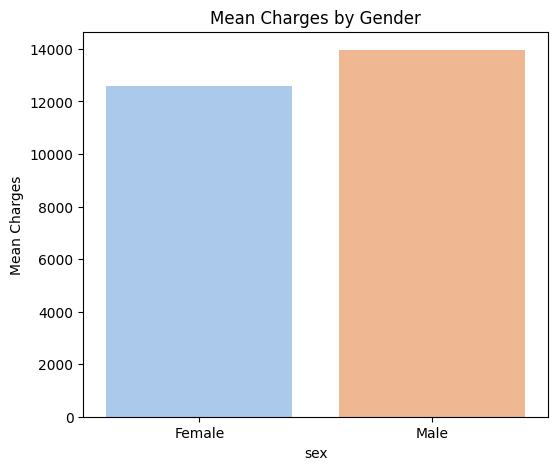

In [ ]:
sex_mean = insurance.groupby('sex')['charges'].mean().reset_index()
sex_mean['sex'] = sex_mean['sex'].map({1:'Male', 0:'Female'})
plt.figure(figsize=(6,5))
sns.barplot(x='sex', y='charges', data=sex_mean, palette='pastel')
plt.title("Mean Charges by Gender")
plt.ylabel("Mean Charges")
plt.show()

In [ ]:
if p_val < 0.05:
  print("Mean charges differ for male and female significantly and with male mean charges being higher")

Mean charges differ for male and female significantly and with male mean charges being higher


In [ ]:
smoker_charges = insurance[insurance['smoker']==1]['charges']
nonsmoker_charges = insurance[insurance['smoker']==0]['charges']
t_stat, p_val = stats.ttest_ind(smoker_charges, nonsmoker_charges)
print(f"T-test (Smoker vs Charges): t = {t_stat:.4f}, p = {p_val:.4f}")

T-test (Smoker vs Charges): t = 46.6649, p = 0.0000


/tmp/ipython-input-1871740693.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='smoker', y='charges', data=smoker_mean, palette='muted')


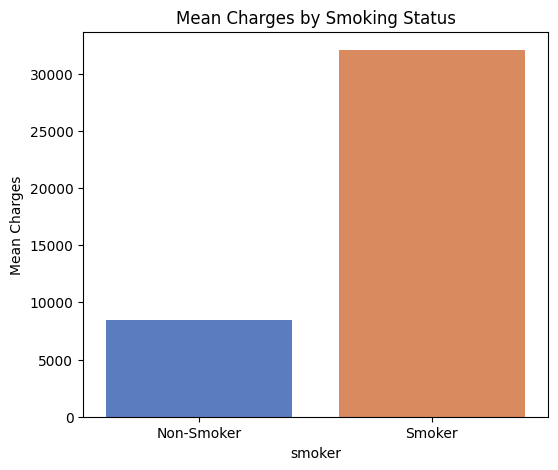

In [ ]:
smoker_mean = insurance.groupby('smoker')['charges'].mean().reset_index()
smoker_mean['smoker'] = smoker_mean['smoker'].map({1:'Smoker', 0:'Non-Smoker'})
plt.figure(figsize=(6,5))
sns.barplot(x='smoker', y='charges', data=smoker_mean, palette='muted')
plt.title("Mean Charges by Smoking Status")
plt.ylabel("Mean Charges")
plt.show()

In [ ]:
if p_val < 0.05:
  print("Mean charges differ for smoker and non smoker significantly and for smoker mean charges are significantly higher than non smokers")

Mean charges differ for smoker and non smoker significantly and for smoker mean charges are significantly higher than non smokers


In [ ]:
regions = insurance['region_original'].unique()
region_charges = [insurance[insurance['region_original']==region]['charges'] for region in regions]
f_stat, p_val = stats.f_oneway(*region_charges)
print(f"ANOVA (Region vs Charges): F = {f_stat:.4f}, p = {p_val:.4f}")

ANOVA (Region vs Charges): F = 2.9696, p = 0.0309


/tmp/ipython-input-441101510.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='region_original', y='charges', data=region_mean, palette='Set2')


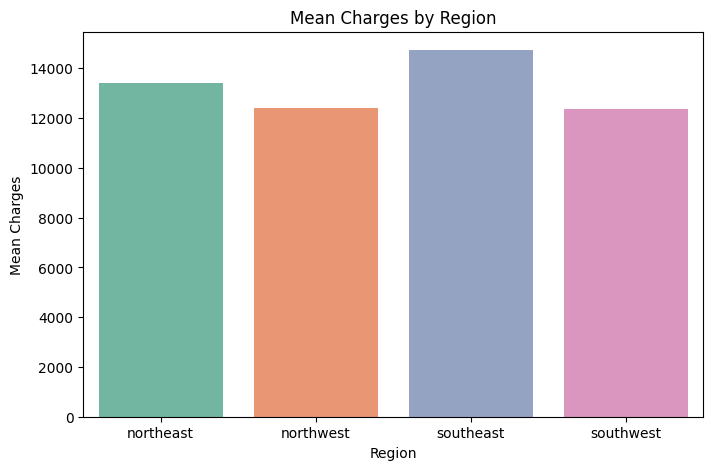

In [ ]:
region_mean = insurance.groupby('region_original')['charges'].mean().reset_index()
plt.figure(figsize=(8,5))
sns.barplot(x='region_original', y='charges', data=region_mean, palette='Set2')
plt.title("Mean Charges by Region")
plt.ylabel("Mean Charges")
plt.xlabel("Region")
plt.show()

In [ ]:
if p_val < 0.05:
  print("Mean charges differ for different regions significantly and with southeast US having highest mean charges")

Mean charges differ for different regions significantly and with southeast US having highest mean charges


/tmp/ipython-input-2244762964.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(x='sex', y='charges', hue='smoker', data=insurance,


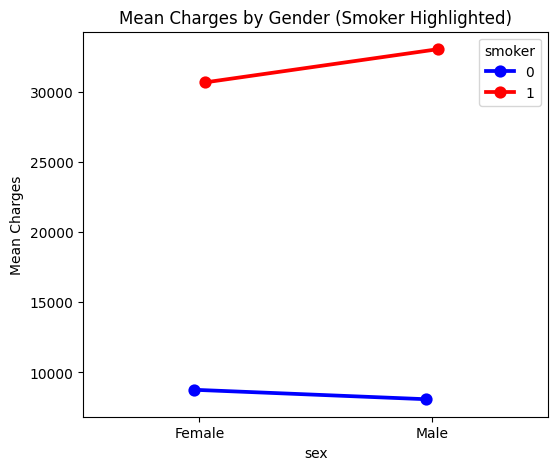

In [ ]:
plt.figure(figsize=(6,5))
sns.pointplot(x='sex', y='charges', hue='smoker', data=insurance,
              palette={0:'blue', 1:'red'}, dodge=True, ci=None)
plt.xticks([0,1], ['Female','Male'])
plt.title("Mean Charges by Gender (Smoker Highlighted)")
plt.ylabel("Mean Charges")
plt.show()

/tmp/ipython-input-4101087410.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(x='region_original', y='charges', hue='smoker', data=insurance,


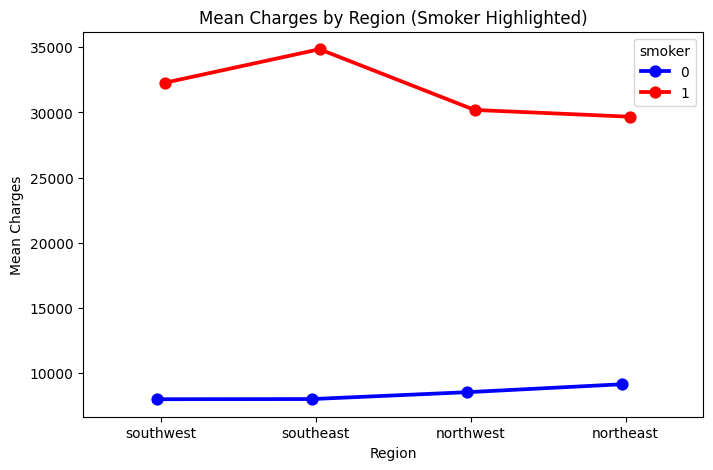

In [ ]:
plt.figure(figsize=(8,5))
sns.pointplot(x='region_original', y='charges', hue='smoker', data=insurance,
              palette={0:'blue',1:'red'}, dodge=True, ci=None)
plt.title("Mean Charges by Region (Smoker Highlighted)")
plt.ylabel("Mean Charges")
plt.xlabel("Region")
plt.show()

In [ ]:
smokers_by_region = insurance.groupby('region_original')['smoker'].sum().reset_index()
smokers_by_region.rename(columns={'smoker':'num_smokers'}, inplace=True)
print("Smokers by Region:")
print(smokers_by_region)

Smokers by Region:
  region_original  num_smokers
0       northeast           67
1       northwest           58
2       southeast           91
3       southwest           58


In [ ]:
print("South-East USA has the highest amount of smokers which increases the mean charges of southeast")

South-East USA has the highest amount of smokers which increases the mean charges of southeast


In [ ]:
smokers_by_gender = insurance.groupby('sex')['smoker'].sum().reset_index()
smokers_by_gender['sex'] = smokers_by_gender['sex'].map({1:'Male',0:'Female'})
smokers_by_gender.rename(columns={'smoker':'num_smokers'}, inplace=True)
print("\nSmokers by Gender:")
print(smokers_by_gender)


Smokers by Gender:
      sex  num_smokers
0  Female          115
1    Male          159


In [ ]:
print("The number of smokers are higher for male compared to female and hence the increased charges")

The number of smokers are higher for male compared to female and hence the increased charges


In [ ]:
smokers_by_age = insurance.groupby('age_group')['smoker'].sum().reset_index()
smokers_by_age.rename(columns={'smoker':'num_smokers'}, inplace=True)
print("\nSmokers by Age Group:")
print(smokers_by_age)


Smokers by Age Group:
  age_group  num_smokers
0     18-24           65
1     25-34           56
2     35-44           61
3     45-54           52
4     55-64           40


/tmp/ipython-input-2950576696.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  smokers_by_age = insurance.groupby('age_group')['smoker'].sum().reset_index()


In [ ]:
smokers_by_children = insurance.groupby('children')['smoker'].sum().reset_index()
smokers_by_children.rename(columns={'smoker':'num_smokers'}, inplace=True)
print("\nSmokers by Number of Children:")
smokers_by_children


Smokers by Number of Children:


,children,num_smokers
0,0,115
1,1,61
2,2,55
3,3,39
4,4,3
5,5,1


In [ ]:
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    outliers = df[(df[column] < lower) | (df[column] > upper)]
    print(f"Number of outliers in {column}: {len(outliers)}")
    return outliers


In [ ]:
outliers_charges = detect_outliers(insurance, 'charges')
outliers_bmi = detect_outliers(insurance, 'bmi')

Number of outliers in charges: 139
Number of outliers in bmi: 9


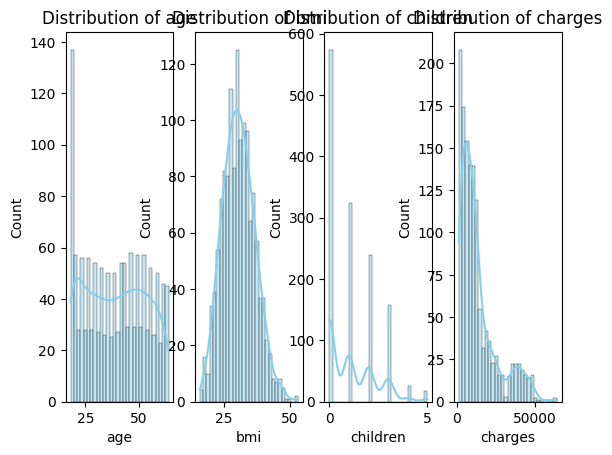

In [ ]:
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(1, 4, i)
    sns.histplot(data=insurance, x=col, kde=True, bins=30, color='skyblue')
    plt.title(f"Distribution of {col}")


In [ ]:
insurance['log_charges'] = np.log(insurance['charges'])

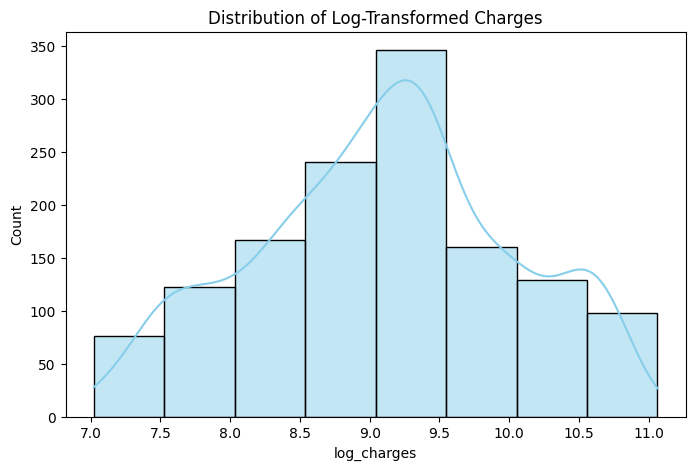

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(insurance['log_charges'], kde=True, bins=8, color='skyblue')
plt.title('Distribution of Log-Transformed Charges')
plt.show()


In [ ]:
outliers_bmi = detect_outliers(insurance, 'bmi')

Number of outliers in bmi: 9


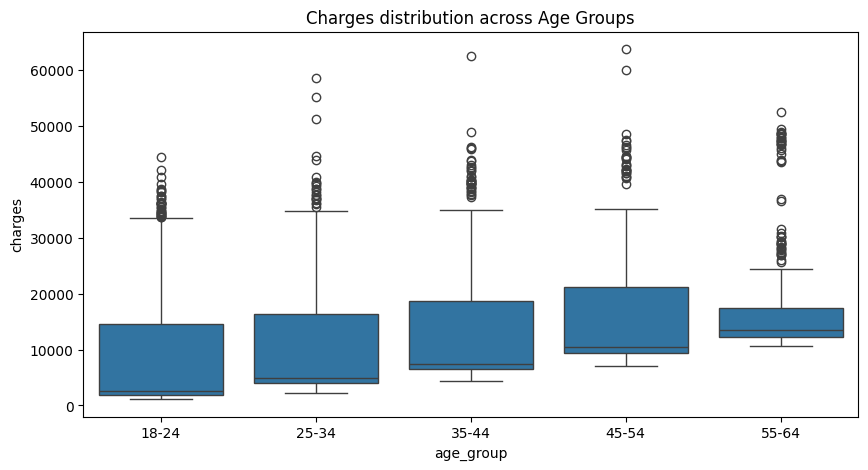

In [ ]:
plt.figure(figsize=(10,5))
sns.boxplot(x='age_group', y='charges', data=insurance)
plt.title('Charges distribution across Age Groups')
plt.show()

/tmp/ipython-input-2747342221.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='age_group', data=insurance, palette='pastel')


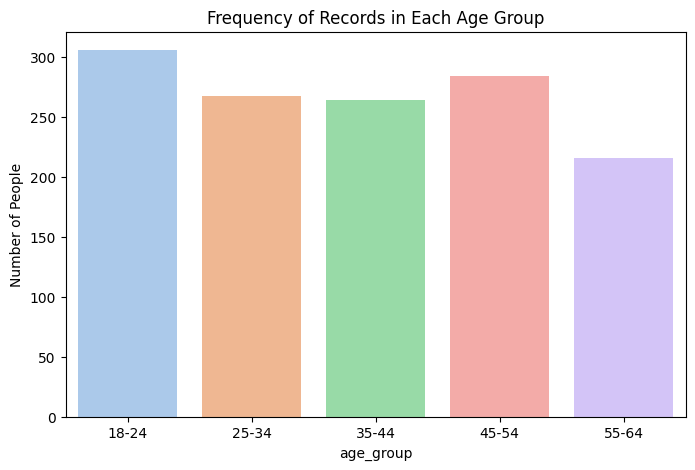

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(x='age_group', data=insurance, palette='pastel')
plt.title('Frequency of Records in Each Age Group')
plt.ylabel('Number of People')
plt.show()

In [ ]:
for col in insurance.columns:
    if insurance[col].dtype == 'bool':
        insurance[col] = insurance[col].astype(int)

In [ ]:
X = insurance.drop(columns=['charges', 'region_original','age_group','log_charges'])  # all numeric and one-hot encoded columns
y = insurance['log_charges']

In [ ]:
# Calculate VIF
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

            Feature        VIF
0               age   7.686965
1               sex   2.003185
2               bmi  11.358443
3          children   1.809930
4            smoker   1.261233
5  region_northwest   1.890281
6  region_southeast   2.265564
7  region_southwest   1.960745


In [ ]:
# VIF of age and bmi is very high but we have very weak correlation between age and bmi so we let it be but if you still want to do something it is not recommended but you can try out pca for fun
scaler = StandardScaler()
age_bmi_scaled = scaler.fit_transform(X[['age','bmi']])

In [ ]:
pca = PCA(n_components=1)
X['age_bmi_pca'] = pca.fit_transform(age_bmi_scaled)

In [ ]:
# Drop original age and bmi to remove multicollinearity
X = X.drop(columns=['age','bmi'])

In [ ]:
X_const = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data['Feature'] = X_const.columns
vif_data['VIF'] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]
print(vif_data)

            Feature       VIF
0             const  6.094259
1               sex  1.006538
2          children  1.003682
3            smoker  1.012059
4  region_northwest  1.518806
5  region_southeast  1.589304
6  region_southwest  1.523549
7       age_bmi_pca  1.038480


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
lr = LinearRegression()

In [ ]:
lr.fit(X_train, y_train)

LinearRegression()

In [ ]:
y_pred = lr.predict(X_test)
y_pred

array([ 9.11460197,  8.63097424, 11.09890997,  9.11828346,  9.55198904,
        8.68960332,  7.94673471,  9.62273203,  8.24029881,  9.2610713 ,
       10.03761867,  8.92049933,  8.39820157, 10.81615193, 10.99879723,
       10.71157421,  9.35358029, 10.66206064,  8.95943084, 10.37975511,
        8.49278914,  8.95018237,  7.91347583,  8.34102567,  9.36191472,
        9.33998206,  9.45580902,  8.60527649,  9.20247264,  7.86218361,
        9.06181214,  9.37467675,  8.10359695,  8.56589491,  8.24020204,
        9.05432162,  8.09436523,  8.89536488, 10.74294471, 10.19156291,
        8.42558526,  8.18772342,  9.42079485,  9.28225507,  8.63705627,
        9.33630301,  8.35128321,  8.38768321, 10.62664875,  8.60446882,
        9.56135439,  7.9441596 ,  9.01544178,  7.94364858,  9.22185462,
        9.30579414,  8.34555034, 10.27386974,  9.36011846,  9.31348848,
        9.51366606,  8.70890029,  9.70664799,  8.95286772,  9.24694347,
        8.39390312,  9.83953705,  9.25300983,  8.24465537,  8.13

In [ ]:
r2 = r2_score(y_test, y_pred)
r2

0.8047311493462987

In [ ]:
n = X_test.shape[0]
p = X_test.shape[1]
adjusted_r2 = 1 - (1-r2)*(n-1)/(n-p-1)
adjusted_r2

0.7986996790558369

In [ ]:
X = sm.add_constant(X)  # add intercept
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            log_charges   R-squared:                       0.686
Model:                            OLS   Adj. R-squared:                  0.685
Method:                 Least Squares   F-statistic:                     415.9
Date:                Sat, 20 Sep 2025   Prob (F-statistic):               0.00
Time:                        13:01:34   Log-Likelihood:                -1010.0
No. Observations:                1338   AIC:                             2036.
Df Residuals:                    1330   BIC:                             2078.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                8.8578      0.035  